<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter11/Generating_deep_fakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('Faceswap-Deepfake-Pytorch'):
    !wget -q https://www.dropbox.com/s/5ji7jl7httso9ny/person_images.zip
    !wget -q https://raw.githubusercontent.com/sizhky/deep-fake-util/main/random_warp.py
    !unzip -q person_images.zip
!pip install -q torch_snippets torch_summary
from torch_snippets import *
from random_warp import get_training_data

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
def crop_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if(len(faces)>0):
        for (x,y,w,h) in faces:
            img2 = img[y:(y+h),x:(x+w),:]
        img2 = cv2.resize(img2,(256,256))
        return img2, True
    else:
        return img, False

In [ ]:
!mkdir cropped_faces_personA
!mkdir cropped_faces_personB

def crop_images(folder):
    images = Glob(folder+'/*.jpg')
    for i in range(len(images)):
        img = read(images[i],1)
        img2, face_detected = crop_face(img)
        if(face_detected==False):
            continue
        else:
            cv2.imwrite('cropped_faces_'+folder+'/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
crop_images('personA')
crop_images('personB')

mkdir: cannot create directory ‘cropped_faces_personA’: File exists
mkdir: cannot create directory ‘cropped_faces_personB’: File exists


2020-11-08 07:23:24.933 | INFO     | torch_snippets.loader:Glob:181 - 444 files found at personA/*.jpg


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, items_A, items_B):
        self.items_A = np.concatenate([read(f,1)[None] for f in items_A])/255.
        self.items_B = np.concatenate([read(f,1)[None] for f in items_B])/255.
        self.items_A += self.items_B.mean(axis=(0, 1, 2)) - self.items_A.mean(axis=(0, 1, 2))

    def __len__(self):
        return min(len(self.items_A), len(self.items_B))
    def __getitem__(self, ix):
        a, b = choose(self.items_A), choose(self.items_B)
        return a, b

    def collate_fn(self, batch):
        imsA, imsB = list(zip(*batch))
        imsA, targetA = get_training_data(imsA, len(imsA))
        imsB, targetB = get_training_data(imsB, len(imsB))
        imsA, imsB, targetA, targetB = [torch.Tensor(i).permute(0,3,1,2).to(device) for i in [imsA, imsB, targetA, targetB]]
        return imsA, imsB, targetA, targetB

a = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
x = DataLoader(a, batch_size=32, collate_fn=a.collate_fn)

2020-11-08 07:16:09.186 | INFO     | torch_snippets.loader:Glob:181 - 349 files found at cropped_faces_personA
2020-11-08 07:16:09.189 | INFO     | torch_snippets.loader:Glob:181 - 105 files found at cropped_faces_personB


Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: -0.006	Max: 0.884	Mean: 0.506	dtype: torch.float32
Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: 0.023	Max: 0.927	Mean: 0.490	dtype: torch.float32
Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: 0.003	Max: 0.882	Mean: 0.506	dtype: torch.float32
Tensor	Shape: torch.Size([32, 3, 64, 64])	Min: 0.023	Max: 0.927	Mean: 0.492	dtype: torch.float32


2020-11-08 07:16:16.342 | INFO     | torch_snippets.loader:subplots:375 - plotting 8 images in a grid of 2x4 @ (5, 5)


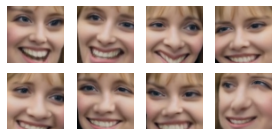

2020-11-08 07:16:16.710 | INFO     | torch_snippets.loader:subplots:375 - plotting 8 images in a grid of 2x4 @ (5, 5)


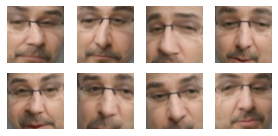

2020-11-08 07:16:17.026 | INFO     | torch_snippets.loader:subplots:375 - plotting 8 images in a grid of 2x4 @ (5, 5)


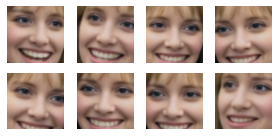

2020-11-08 07:16:17.411 | INFO     | torch_snippets.loader:subplots:375 - plotting 8 images in a grid of 2x4 @ (5, 5)


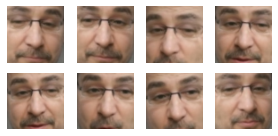

In [ ]:
inspect(*next(iter(x)))

for i in next(iter(x)):
    subplots(i[:8], nc=4, sz=(4,2))

In [ ]:
def _ConvLayer(input_features, output_features):
    return nn.Sequential(
        nn.Conv2d(input_features, output_features, kernel_size=5, stride=2, padding=2),
        nn.LeakyReLU(0.1, inplace=True)
    )

def _UpScale(input_features, output_features):
    return nn.Sequential(
        nn.ConvTranspose2d(input_features, output_features, kernel_size=2, stride=2, padding=0),
        nn.LeakyReLU(0.1, inplace=True)
    )

class Reshape(nn.Module):
    def forward(self, input):
        output = input.view(-1, 1024, 4, 4) # channel * 4 * 4
        return output

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            _ConvLayer(3, 128),
            _ConvLayer(128, 256),
            _ConvLayer(256, 512),
            _ConvLayer(512, 1024),
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1024),
            nn.Linear(1024, 1024 * 4 * 4),
            Reshape(),
            _UpScale(1024, 512),
        )

        self.decoder_A = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

        self.decoder_B = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, select='A'):
        if select == 'A':
            out = self.encoder(x)
            out = self.decoder_A(out)
        else:
            out = self.encoder(x)
            out = self.decoder_B(out)
        return out

In [ ]:
from torchsummary import summary
model = Autoencoder()
summary(model, torch.zeros(32,3,64,64), 'A');

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 8, 8]           --
|    └─Sequential: 2-1                   [-1, 128, 32, 32]         --
|    |    └─Conv2d: 3-1                  [-1, 128, 32, 32]         9,728
|    |    └─LeakyReLU: 3-2               [-1, 128, 32, 32]         --
|    └─Sequential: 2-2                   [-1, 256, 16, 16]         --
|    |    └─Conv2d: 3-3                  [-1, 256, 16, 16]         819,456
|    |    └─LeakyReLU: 3-4               [-1, 256, 16, 16]         --
|    └─Sequential: 2-3                   [-1, 512, 8, 8]           --
|    |    └─Conv2d: 3-5                  [-1, 512, 8, 8]           3,277,312
|    |    └─LeakyReLU: 3-6               [-1, 512, 8, 8]           --
|    └─Sequential: 2-4                   [-1, 1024, 4, 4]          --
|    |    └─Conv2d: 3-7                  [-1, 1024, 4, 4]          13,108,224
|    |    └─LeakyReLU: 3-8               [-1, 1024, 4, 4]     

In [ ]:
def train_batch(model, data, criterion, optimizes):
    optA, optB = optimizers
    optA.zero_grad()
    optB.zero_grad()
    imgA, imgB, targetA, targetB = data
    _imgA, _imgB = model(imgA, 'A'), model(imgB, 'B')

    lossA = criterion(_imgA, targetA)
    lossB = criterion(_imgB, targetB)
    
    lossA.backward()
    lossB.backward()

    optA.step()
    optB.step()

    return lossA.item(), lossB.item()

In [ ]:
model = Autoencoder().to(device)

dataset = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
dataloader = DataLoader(dataset, 32, collate_fn=dataset.collate_fn)

optimizers = optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_A.parameters()}],
                        lr=5e-5, betas=(0.5, 0.999)), \
             optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_B.parameters()}], 
                        lr=5e-5, betas=(0.5, 0.999))
             
criterion = nn.L1Loss()

2020-11-08 07:16:45.033 | INFO     | torch_snippets.loader:Glob:181 - 349 files found at cropped_faces_personA
2020-11-08 07:16:45.036 | INFO     | torch_snippets.loader:Glob:181 - 105 files found at cropped_faces_personB


mkdir: cannot create directory ‘checkpoint’: File exists
EPOCH: 1.000	lossA: 0.139	lossB: 0.149	(1.76s - 17552.61s remaining)
EPOCH: 2.000	lossA: 0.137	lossB: 0.149	(2.62s - 13099.50s remaining)
EPOCH: 3.000	lossA: 0.134	lossB: 0.142	(3.49s - 11622.35s remaining)
EPOCH: 4.000	lossA: 0.118	lossB: 0.125	(4.37s - 10921.87s remaining)
EPOCH: 5.000	lossA: 0.109	lossB: 0.113	(5.25s - 10493.76s remaining)
EPOCH: 6.000	lossA: 0.096	lossB: 0.105	(6.15s - 10247.40s remaining)
EPOCH: 7.000	lossA: 0.093	lossB: 0.103	(7.02s - 10028.24s remaining)
EPOCH: 8.000	lossA: 0.092	lossB: 0.102	(7.91s - 9874.61s remaining))
EPOCH: 9.000	lossA: 0.094	lossB: 0.099	(8.90s - 9878.02s remaining))
EPOCH: 10.000	lossA: 0.093	lossB: 0.103	(10.01s - 10003.98s remaining)
EPOCH: 11.000	lossA: 0.093	lossB: 0.099	(10.93s - 9929.14s remaining))
EPOCH: 12.000	lossA: 0.090	lossB: 0.098	(11.84s - 9851.34s remaining)
EPOCH: 13.000	lossA: 0.093	lossB: 0.102	(12.87s - 9889.94s remaining)
EPOCH: 14.000	lossA: 0.096	lossB: 0.102	

2020-11-08 07:18:21.553 | INFO     | torch_snippets.loader:subplots:375 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================A TO B==============================


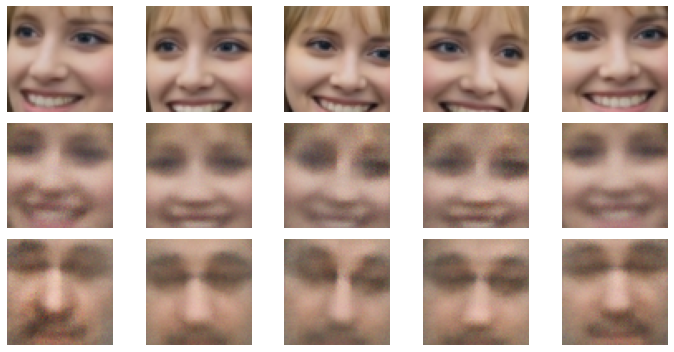

2020-11-08 07:18:22.547 | INFO     | torch_snippets.loader:subplots:375 - plotting 15 images in a grid of 3x5 @ (10, 5)


==============================B TO A==============================


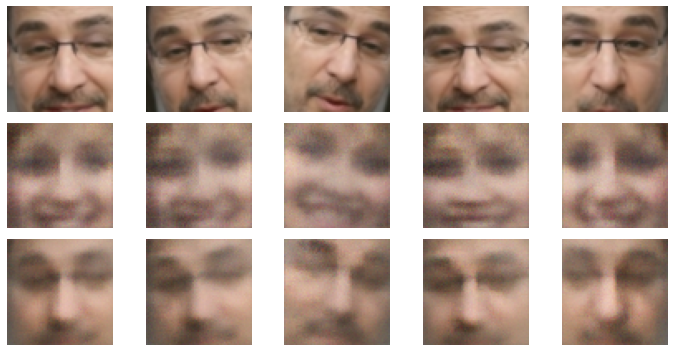

EPOCH: 101.000	lossA: 0.061	lossB: 0.051	(96.39s - 9447.10s remaining)
EPOCH: 102.000	lossA: 0.063	lossB: 0.051	(97.27s - 9439.45s remaining)
EPOCH: 103.000	lossA: 0.063	lossB: 0.053	(98.21s - 9437.00s remaining)
EPOCH: 104.000	lossA: 0.058	lossB: 0.051	(99.11s - 9431.09s remaining)
EPOCH: 105.000	lossA: 0.060	lossB: 0.049	(100.01s - 9424.46s remaining)
EPOCH: 106.000	lossA: 0.062	lossB: 0.052	(101.20s - 9445.77s remaining)
EPOCH: 106.250	lossA: 0.058	lossB: 0.051	(101.45s - 9446.94s remaining)

KeyboardInterrupt: 

In [ ]:
n_epochs = 10000
log = Report(n_epochs)
!mkdir checkpoint
for ex in range(n_epochs):
    N = len(dataloader)
    for bx,data in enumerate(dataloader):
        lossA, lossB = train_batch(model, data, criterion, optimizers)
        log.record(ex+(1+bx)/N, lossA=lossA, lossB=lossB, end='\r')

    log.report_avgs(ex+1)
    if (ex+1)%100 == 0:
        state = {
                'state': model.state_dict(),
                'epoch': ex
            }
        torch.save(state, './checkpoint/autoencoder.pth')

    if (ex+1)%100 == 0:
        bs = 5
        a,b,A,B = data
        line('A to B')
        _a = model(a[:bs], 'A')
        _b = model(a[:bs], 'B')
        x = torch.cat([A[:bs],_a,_b])
        subplots(x, nc=bs, figsize=(bs*2, 5))

        line('B to A')
        _a = model(b[:bs], 'A')
        _b = model(b[:bs], 'B')
        x = torch.cat([B[:bs],_a,_b])
        subplots(x, nc=bs, figsize=(bs*2, 5))

log.plot_epochs()